In [661]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [662]:
df = pd.read_csv("./bse_eq_15min_2025.csv").set_index("datetime").drop(columns=["timestamp"])
df.head()

,open,high,low,close,volume
datetime,,,,,
2025-01-01 09:30:00+05:30,1776.00,1781.90,1765.33,1776.62,178887
2025-01-01 09:45:00+05:30,1776.67,1781.33,1771.48,1776.33,81945
2025-01-01 10:00:00+05:30,1776.67,1798.15,1776.02,1795.67,253758
2025-01-01 10:15:00+05:30,1795.67,1795.95,1783.70,1789.65,115944
2025-01-01 10:30:00+05:30,1789.10,1797.83,1788.77,1793.23,97950


#### Creating Features

    Volume

In [663]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"] / df["volume_ma"]

# Clean up
df = df.dropna(how="any")

    RSI

In [664]:
# RSI calculation
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI with standard 14-period
df["rsi_14"] = calculate_rsi(df["close"], period=14)

# Clean up
df = df.dropna(how="any")

# Check the feature
print("RSI Statistics:")
print(df["rsi_14"].describe())
print(f"\nOverbought (>70): {(df['rsi_14'] > 70).sum()} bars")
print(f"Oversold (<30): {(df['rsi_14'] < 30).sum()} bars")


RSI Statistics:
count    5986.000000
mean       50.055546
std        19.251705
min         2.094769
25%        35.065471
50%        50.379257
75%        64.622139
max        97.186701
Name: rsi_14, dtype: float64

Overbought (>70): 1033 bars
Oversold (<30): 1023 bars


    MACD

In [665]:
# MACD calculation
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize MACD features by price (make them relative)
df["macd_norm"] = df["macd"] / df["close"]
df["macd_hist_norm"] = df["macd_hist"] / df["close"]

# Clean up
df = df.dropna(how="any")

print("MACD Statistics:")
print(df[["macd_norm", "macd_hist_norm"]].describe())

MACD Statistics:
         macd_norm  macd_hist_norm
count  5986.000000     5986.000000
mean      0.000320        0.000009
std       0.007332        0.001926
min      -0.031819       -0.011353
25%      -0.003583       -0.001050
50%       0.000508       -0.000051
75%       0.004226        0.000892
max       0.038440        0.014145


    Moving Averages

In [666]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].rolling(5).mean()
df["10ma"] = df["close"].rolling(10).mean()
df["50ma"] = df["close"].rolling(50).mean()
df["200ma"] = df["close"].rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"]
df["close_5ma_diff_pct"] = (df["close"] - df["5ma"]) / df["close"]
df["close_10ma_diff_pct"] = (df["close"] - df["10ma"]) / df["close"]
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"]

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"] - df["50ma"]) / df["close"]
df["close_200ma_diff_pct"] = (df["close"] - df["200ma"]) / df["close"]

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


In [667]:
# High-Low range features
df["hl_range"] = (df["high"] - df["low"]) / df["close"]  # Normalized
df["hl_range_ma"] = df["hl_range"].rolling(20).mean()
df["hl_range_ratio"] = df["hl_range"] / df["hl_range_ma"]  # Current vs average

# Close position within bar
df["close_position"] = (df["close"] - df["low"]) / (df["high"] - df["low"])  # 0 to 1

df = df.dropna()

    Candlestick/Microstructure Features

In [668]:
# === CANDLESTICK BODY & WICKS ===
df["body_size"] = abs(df["close"] - df["open"]) / df["close"]
df["upper_wick"] = (df["high"] - df[["open", "close"]].max(axis=1)) / df["close"]
df["lower_wick"] = (df[["open", "close"]].min(axis=1) - df["low"]) / df["close"]

# Body direction
df["body_direction"] = np.sign(df["close"] - df["open"])

# === OPEN-CLOSE RELATIONSHIPS ===
df["open_close_diff"] = (df["close"] - df["open"]) / df["close"]
df["high_close_diff"] = (df["high"] - df["close"]) / df["close"]
df["low_close_diff"] = (df["close"] - df["low"]) / df["close"]

# === VOLUME-WEIGHTED PRICE (VWAP) ===
df["vwap_5"] = (df["close"] * df["volume"]).rolling(5).sum() / df["volume"].rolling(5).sum()
df["vwap_10"] = (df["close"] * df["volume"]).rolling(10).sum() / df["volume"].rolling(10).sum()
df["vwap_5_diff"] = (df["close"] - df["vwap_5"]) / df["close"]
df["vwap_10_diff"] = (df["close"] - df["vwap_10"]) / df["close"]

# === MOMENTUM OF MICROSTRUCTURE ===
df["close_position_change"] = df["close_position"].diff()
df["body_size_ratio"] = df["body_size"] / df["body_size"].rolling(10).mean()

# === BUYING/SELLING PRESSURE PROXIES ===
# Approximation: If close near high = buying pressure
df["buying_pressure"] = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
df["selling_pressure"] = (df["high"] - df["close"]) / (df["high"] - df["low"] + 1e-10)

# Clean up
df = df.dropna()

print(f"Added microstructure features. New shape: {df.shape}")

Added microstructure features. New shape: (5777, 44)


#### Creating Target

In [669]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(how="any")

    Shift to avoid lookahead bias

In [670]:
df = df.copy()
df["shifted_log_return"] = df["close_log_return"].shift(-1)

In [671]:
df["close_log_return_lag1"] = df["shifted_log_return"].shift(1)
df["close_log_return_lag2"] = df["shifted_log_return"].shift(2)
df["close_log_return_lag3"] = df["shifted_log_return"].shift(3)
df = df.dropna(how="any")

    Creating Target and Deciding Features

In [672]:
X = df[[
    "buying_pressure",
    "selling_pressure",
    "close_position",
    "close_5ma_diff_pct",
    "high_close_diff",
    "vwap_5_diff",
    "body_size",
    "body_size_ratio",
    "volume_ratio",
    "low_close_diff"
]]


y = (df["shifted_log_return"] > 0).astype(int)


#### Model

datetime
2025-08-05 11:15:00+05:30    1
2025-08-05 11:30:00+05:30    0
2025-08-05 11:45:00+05:30    0
2025-08-05 12:00:00+05:30    1
2025-08-05 12:15:00+05:30    1
                            ..
2025-10-13 11:00:00+05:30    1
2025-10-13 11:15:00+05:30    0
2025-10-13 11:30:00+05:30    0
2025-10-13 11:45:00+05:30    1
2025-10-13 12:00:00+05:30    1
Name: shifted_log_return, Length: 1154, dtype: int64
Test score - 0.5142857142857142
Validation score - 0.47227036395147315
Train score - 1.0
Train confusion matrix - [[310 291]
 [270 284]]
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       601
           1       0.49      0.51      0.50       554

    accuracy                           0.51      1155
   macro avg       0.51      0.51      0.51      1155
weighted avg       0.52      0.51      0.51      1155

Training Accuracy Scores: [0.5223794397920878, 0.5356627201848109, 0.5558764077389546]
Validation Accuracy Scores: [0.518197573656845

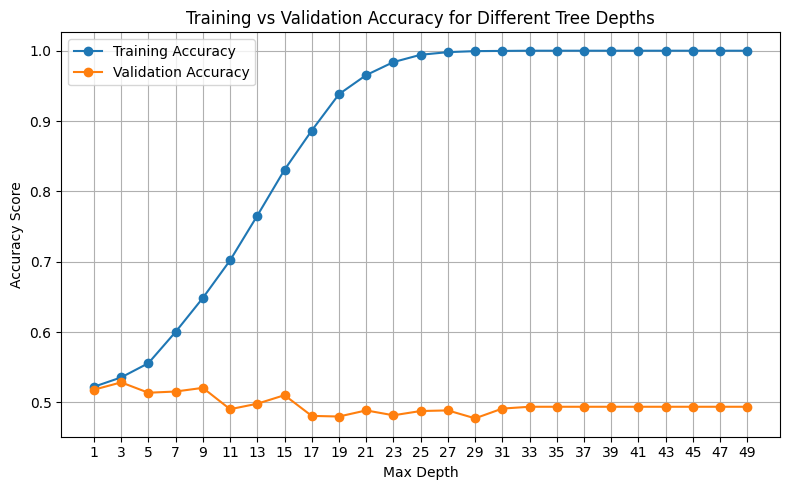

In [673]:
model_preparation(X, y)

In [674]:
model = best_model(X, y, max_depth=3)

Test score - 0.5064935064935064
Validation score - 0.5285961871750433
Train score - 0.5356627201848109
Train confusion matrix - [[138 463]
 [107 447]]
              precision    recall  f1-score   support

           0       0.56      0.23      0.33       601
           1       0.49      0.81      0.61       554

    accuracy                           0.51      1155
   macro avg       0.53      0.52      0.47      1155
weighted avg       0.53      0.51      0.46      1155



#### Feature Importance

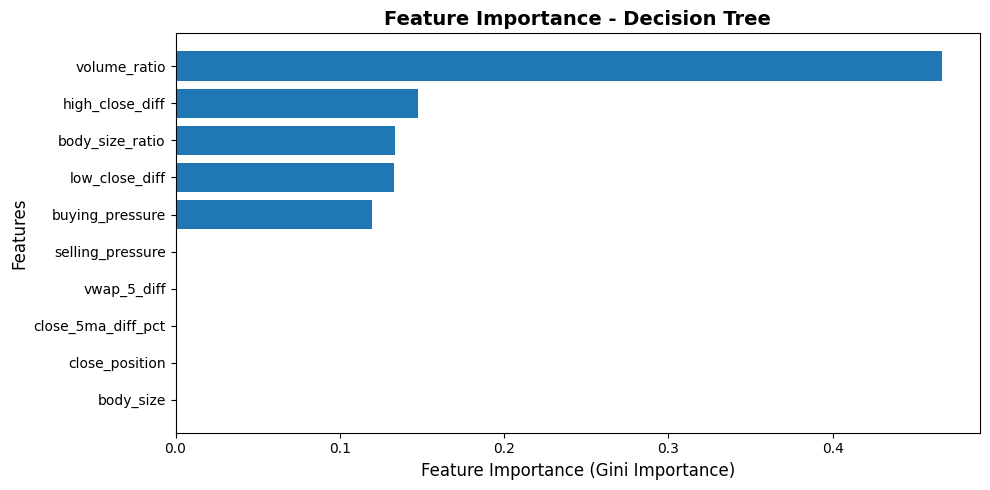


Top 10 Most Important Features:
           feature  importance
      volume_ratio    0.466278
   high_close_diff    0.147652
   body_size_ratio    0.133266
    low_close_diff    0.133104
   buying_pressure    0.119701
  selling_pressure    0.000000
       vwap_5_diff    0.000000
close_5ma_diff_pct    0.000000
    close_position    0.000000
         body_size    0.000000

Bottom 10 Least Important Features:
           feature  importance
      volume_ratio    0.466278
   high_close_diff    0.147652
   body_size_ratio    0.133266
    low_close_diff    0.133104
   buying_pressure    0.119701
  selling_pressure    0.000000
       vwap_5_diff    0.000000
close_5ma_diff_pct    0.000000
    close_position    0.000000
         body_size    0.000000

5 features have ZERO importance (consider removing):
['selling_pressure', 'vwap_5_diff', 'close_5ma_diff_pct', 'close_position', 'body_size']


In [675]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the decision tree
feature_importance = pd.DataFrame({
    'feature': X.columns,  # Your feature names
    'importance': model.feature_importances_  # Feature importances for tree models
}).sort_values('importance', ascending=False)

# Create the chart
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance (Gini Importance)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

# Print top 10 features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Print bottom 10 features (least important)
print("\nBottom 10 Least Important Features:")
print(feature_importance.tail(10).to_string(index=False))

# Show features with zero importance (can be removed)
zero_importance = feature_importance[feature_importance['importance'] == 0]
if len(zero_importance) > 0:
    print(f"\n{len(zero_importance)} features have ZERO importance (consider removing):")
    print(zero_importance['feature'].tolist())

#### Trade Results

In [676]:
# Step 1: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

    # Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [677]:
# Create equity_df from TEST SET ONLY
equity_df = pd.DataFrame()
equity_df["y_true"] = y_test
equity_df["log_returns"] = df["shifted_log_return"].iloc[len(X_train) + len(X_val):]  # Get test set returns

# Get predictions and probabilities for test set
pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
max_confidence = np.max(pred_proba, axis=1)

# Set confidence threshold
CONFIDENCE_THRESHOLD = 0.70

equity_df['confidence'] = max_confidence
equity_df['y_pred_raw'] = y_pred

# Filter: only use predictions when confidence is high enough
equity_df['y_pred'] = np.where(
    equity_df['confidence'] >= CONFIDENCE_THRESHOLD,
    equity_df['y_pred_raw'],
    0  # No position when confidence < threshold
)

# Reset index to avoid any alignment issues
equity_df = equity_df.reset_index(drop=True)

#### Capturing all ups and downs

In [678]:
# Step 1: Position based on prediction
equity_df['position'] = equity_df['y_pred']

# Step 2: Transaction costs - only when position changes (round trip)
TRANSACTION_COST_PCT = 0.0004  # 0.04% per round trip

# Detect position changes (entry/exit = round trip)
equity_df['position_change'] = equity_df['position'].diff().fillna(equity_df['position']).abs()

# Cost applied per $100 position when trade happens
equity_df['transaction_cost'] = equity_df['position_change'] * 100 * TRANSACTION_COST_PCT

# Step 3: Calculate P&L for each independent $100 trade
equity_df['pnl_gross'] = equity_df['position'] * equity_df['log_returns'] * 100
equity_df['pnl_net'] = equity_df['pnl_gross'] - equity_df['transaction_cost']

# Step 4: Calculate cumulative P&L (simple sum, not compounding)
equity_df['cumulative_pnl'] = equity_df['pnl_net'].cumsum()

# Step 5: Equity curve (starting capital + cumulative P&L)
equity_df['equity'] = 100 + equity_df['cumulative_pnl']

# Summary statistics
total_trades = (equity_df['position_change'] > 0).sum()  # Actual trades (position changes)
total_bars = len(equity_df)
winning_trades = (equity_df['pnl_net'] > 0).sum()
losing_trades = (equity_df['pnl_net'] < 0).sum()

total_gross_pnl = equity_df['pnl_gross'].sum()
total_costs = equity_df['transaction_cost'].sum()
total_net_pnl = equity_df['pnl_net'].sum()

print(f"\n{'='*50}")
print(f"PERFORMANCE SUMMARY")
print(f"{'='*50}")
print(f"Total bars: {total_bars}")
print(f"Total trades (position changes): {total_trades}")
print(f"Winning bars: {winning_trades}")
print(f"Losing bars: {losing_trades}")
print(f"Win rate: {winning_trades / total_bars * 100:.2f}%")
print(f"\nGross P&L: ${total_gross_pnl:.2f}")
print(f"Transaction costs: ${total_costs:.2f} ({total_costs/abs(total_gross_pnl)*100:.2f}% of gross)")
print(f"Net P&L: ${total_net_pnl:.2f}")
print(f"Final equity: ${equity_df['equity'].iloc[-1]:.2f}")
print(f"Net Return: {total_net_pnl:.2f}%")
print(f"\nAvg win: ${equity_df[equity_df['pnl_net'] > 0]['pnl_net'].mean():.2f}")
print(f"Avg loss: ${equity_df[equity_df['pnl_net'] < 0]['pnl_net'].mean():.2f}")

total_wins = equity_df[equity_df['pnl_net'] > 0]['pnl_net'].sum()
total_losses = abs(equity_df[equity_df['pnl_net'] < 0]['pnl_net'].sum())
profit_factor = (total_wins / total_losses) if total_losses > 0 else np.inf

print(f"Profit factor: {profit_factor:.2f}")
print(f"\nSharpe Ratio: {equity_df['pnl_net'].mean() / equity_df['pnl_net'].std() * np.sqrt(252 * 75):.2f}")

drawdown = equity_df['equity'].cummax() - equity_df['equity']
max_dd = drawdown.max()
max_dd_pct = (max_dd / equity_df['equity'].cummax()[drawdown.idxmax()]) * 100

print(f"Max Drawdown: ${max_dd:.2f} ({max_dd_pct:.2f}%)")
print(f"{'='*50}\n")


PERFORMANCE SUMMARY
Total bars: 1155
Total trades (position changes): 4
Winning bars: 0
Losing bars: 4
Win rate: 0.00%

Gross P&L: $-0.20
Transaction costs: $0.16 (80.39% of gross)
Net P&L: $-0.36
Final equity: $99.64
Net Return: -0.36%

Avg win: $nan
Avg loss: $-0.09
Profit factor: 0.00

Sharpe Ratio: -5.39
Max Drawdown: $0.36 (0.36%)



#### Threshold of 51%

In [679]:
# STEP 0: Get prediction probabilities and filter by confidence
pred_proba = model.predict_proba(X_test)  # Get probabilities for both classes
max_confidence = np.max(pred_proba, axis=1)  # Max probability across classes

# Create filtered predictions
# Only take positions when confidence > 70%, otherwise stay out (position = 0)
CONFIDENCE_THRESHOLD = 0.51

equity_df['confidence'] = max_confidence
equity_df['y_pred_raw'] = y_pred  # Store original predictions

# Filter: only use predictions when confidence is high enough
equity_df['y_pred'] = np.where(
    equity_df['confidence'] >= CONFIDENCE_THRESHOLD,
    equity_df['y_pred_raw'],
    0  # No position when confidence < threshold
)

# Step 1: Position based on filtered prediction
equity_df['position'] = equity_df['y_pred']

# Step 2: Transaction costs - only when position changes (round trip)
TRANSACTION_COST_PCT = 0.0004  # 0.04% per round trip

# Detect position changes (entry/exit = round trip)
equity_df['position_change'] = equity_df['position'].diff().fillna(equity_df['position']).abs()

# Cost applied per $100 position when trade happens
equity_df['transaction_cost'] = equity_df['position_change'] * 100 * TRANSACTION_COST_PCT

# Step 3: Calculate P&L for each independent $100 trade
equity_df['pnl_gross'] = equity_df['position'] * equity_df['log_returns'] * 100
equity_df['pnl_net'] = equity_df['pnl_gross'] - equity_df['transaction_cost']

# Step 4: Calculate cumulative P&L (simple sum, not compounding)
equity_df['cumulative_pnl'] = equity_df['pnl_net'].cumsum()

# Step 5: Equity curve (starting capital + cumulative P&L)
equity_df['equity'] = 100 + equity_df['cumulative_pnl']

# Summary statistics
total_trades = (equity_df['position_change'] > 0).sum()
total_bars = len(equity_df)
bars_in_market = (equity_df['position'] != 0).sum()
bars_out_market = (equity_df['position'] == 0).sum()

winning_trades = (equity_df['pnl_net'] > 0).sum()
losing_trades = (equity_df['pnl_net'] < 0).sum()

total_gross_pnl = equity_df['pnl_gross'].sum()
total_costs = equity_df['transaction_cost'].sum()
total_net_pnl = equity_df['pnl_net'].sum()

print(f"\n{'='*50}")
print(f"PERFORMANCE SUMMARY (Confidence >= {CONFIDENCE_THRESHOLD*100:.0f}%)")
print(f"{'='*50}")
print(f"Total bars: {total_bars}")
print(f"Bars in market: {bars_in_market} ({bars_in_market/total_bars*100:.1f}%)")
print(f"Bars out of market: {bars_out_market} ({bars_out_market/total_bars*100:.1f}%)")
print(f"Total trades (position changes): {total_trades}")
print(f"Winning bars: {winning_trades}")
print(f"Losing bars: {losing_trades}")
if bars_in_market > 0:
    print(f"Win rate (when in market): {winning_trades / bars_in_market * 100:.2f}%")

print(f"\nGross P&L: ${total_gross_pnl:.2f}")
print(f"Transaction costs: ${total_costs:.2f}", end="")
if abs(total_gross_pnl) > 0:
    print(f" ({total_costs/abs(total_gross_pnl)*100:.2f}% of gross)")
else:
    print()
print(f"Net P&L: ${total_net_pnl:.2f}")
print(f"Final equity: ${equity_df['equity'].iloc[-1]:.2f}")
print(f"Net Return: {total_net_pnl:.2f}%")

if winning_trades > 0:
    print(f"\nAvg win: ${equity_df[equity_df['pnl_net'] > 0]['pnl_net'].mean():.2f}")
if losing_trades > 0:
    print(f"Avg loss: ${equity_df[equity_df['pnl_net'] < 0]['pnl_net'].mean():.2f}")

total_wins = equity_df[equity_df['pnl_net'] > 0]['pnl_net'].sum()
total_losses = abs(equity_df[equity_df['pnl_net'] < 0]['pnl_net'].sum())
profit_factor = (total_wins / total_losses) if total_losses > 0 else np.inf

print(f"Profit factor: {profit_factor:.2f}")

if equity_df['pnl_net'].std() > 0:
    print(f"\nSharpe Ratio: {equity_df['pnl_net'].mean() / equity_df['pnl_net'].std() * np.sqrt(252 * 75):.2f}")

drawdown = equity_df['equity'].cummax() - equity_df['equity']
max_dd = drawdown.max()
if drawdown.idxmax() in equity_df.index:
    max_dd_pct = (max_dd / equity_df['equity'].cummax()[drawdown.idxmax()]) * 100
    print(f"Max Drawdown: ${max_dd:.2f} ({max_dd_pct:.2f}%)")

print(f"{'='*50}\n")

# Optional: Show confidence distribution
print(f"\nConfidence Distribution:")
print(f"  >= 70%: {(equity_df['confidence'] >= 0.70).sum()} bars ({(equity_df['confidence'] >= 0.70).sum()/len(equity_df)*100:.1f}%)")
print(f"  >= 60%: {(equity_df['confidence'] >= 0.60).sum()} bars ({(equity_df['confidence'] >= 0.60).sum()/len(equity_df)*100:.1f}%)")
print(f"  >= 50%: {(equity_df['confidence'] >= 0.50).sum()} bars ({(equity_df['confidence'] >= 0.50).sum()/len(equity_df)*100:.1f}%)")


PERFORMANCE SUMMARY (Confidence >= 51%)
Total bars: 1155
Bars in market: 696 (60.3%)
Bars out of market: 459 (39.7%)
Total trades (position changes): 316
Winning bars: 347
Losing bars: 504
Win rate (when in market): 49.86%

Gross P&L: $20.45
Transaction costs: $12.64 (61.81% of gross)
Net P&L: $7.81
Final equity: $107.81
Net Return: 7.81%

Avg win: $0.33
Avg loss: $-0.21
Profit factor: 1.07

Sharpe Ratio: 2.36
Max Drawdown: $14.58 (12.39%)


Confidence Distribution:
  >= 70%: 34 bars (2.9%)
  >= 60%: 72 bars (6.2%)
  >= 50%: 1155 bars (100.0%)


#### Long Only 

In [680]:
# Get predictions for test set
y_pred = model.predict(X_test)

# Long-only strategy: only hold position when predicting up (class 1)
# Position = 1 when model predicts up, 0 otherwise (flat/cash)
equity_df['y_pred'] = y_pred
equity_df['position'] = np.where(equity_df['y_pred'] == 1, 1, 0)

# Step 2: Transaction costs - only when position changes (round trip)
TRANSACTION_COST_PCT = 0.0004  # 0.04% per round trip

# Detect position changes (entry/exit = round trip)
equity_df['position_change'] = equity_df['position'].diff().fillna(equity_df['position']).abs()

# Cost applied per $100 position when trade happens
equity_df['transaction_cost'] = equity_df['position_change'] * 100 * TRANSACTION_COST_PCT

# Step 3: Calculate P&L for each independent $100 trade
equity_df['pnl_gross'] = equity_df['position'] * equity_df['log_returns'] * 100
equity_df['pnl_net'] = equity_df['pnl_gross'] - equity_df['transaction_cost']

# Step 4: Calculate cumulative P&L (simple sum, not compounding)
equity_df['cumulative_pnl'] = equity_df['pnl_net'].cumsum()

# Step 5: Equity curve (starting capital + cumulative P&L)
equity_df['equity'] = 100 + equity_df['cumulative_pnl']

# Summary statistics
total_trades = (equity_df['position_change'] > 0).sum()
total_bars = len(equity_df)
bars_in_market = (equity_df['position'] != 0).sum()
bars_out_market = (equity_df['position'] == 0).sum()

winning_bars = (equity_df['pnl_net'] > 0).sum()
losing_bars = (equity_df['pnl_net'] < 0).sum()

total_gross_pnl = equity_df['pnl_gross'].sum()
total_costs = equity_df['transaction_cost'].sum()
total_net_pnl = equity_df['pnl_net'].sum()

print(f"\n{'='*50}")
print(f"LONG-ONLY STRATEGY (Buy when predicting UP)")
print(f"{'='*50}")
print(f"Total bars: {total_bars}")
print(f"Bars in market (long): {bars_in_market} ({bars_in_market/total_bars*100:.1f}%)")
print(f"Bars out of market (cash): {bars_out_market} ({bars_out_market/total_bars*100:.1f}%)")
print(f"Total trades (position changes): {total_trades}")
print(f"Winning bars: {winning_bars}")
print(f"Losing bars: {losing_bars}")

if bars_in_market > 0:
    print(f"Win rate (when in market): {winning_bars / bars_in_market * 100:.2f}%")

print(f"\nGross P&L: ${total_gross_pnl:.2f}")
print(f"Transaction costs: ${total_costs:.2f}", end="")
if abs(total_gross_pnl) > 0:
    print(f" ({total_costs/abs(total_gross_pnl)*100:.2f}% of gross)")
else:
    print()
    
print(f"Net P&L: ${total_net_pnl:.2f}")
print(f"Final equity: ${equity_df['equity'].iloc[-1]:.2f}")
print(f"Net Return: {total_net_pnl:.2f}%")

if winning_bars > 0:
    print(f"\nAvg win: ${equity_df[equity_df['pnl_net'] > 0]['pnl_net'].mean():.2f}")
if losing_bars > 0:
    print(f"Avg loss: ${equity_df[equity_df['pnl_net'] < 0]['pnl_net'].mean():.2f}")

total_wins = equity_df[equity_df['pnl_net'] > 0]['pnl_net'].sum()
total_losses = abs(equity_df[equity_df['pnl_net'] < 0]['pnl_net'].sum())
profit_factor = (total_wins / total_losses) if total_losses > 0 else np.inf

print(f"Profit factor: {profit_factor:.2f}")

if equity_df['pnl_net'].std() > 0:
    print(f"\nSharpe Ratio: {equity_df['pnl_net'].mean() / equity_df['pnl_net'].std() * np.sqrt(252 * 75):.2f}")

drawdown = equity_df['equity'].cummax() - equity_df['equity']
max_dd = drawdown.max()
if drawdown.idxmax() in equity_df.index:
    max_dd_pct = (max_dd / equity_df['equity'].cummax()[drawdown.idxmax()]) * 100
    print(f"Max Drawdown: ${max_dd:.2f} ({max_dd_pct:.2f}%)")

print(f"{'='*50}\n")

# Show how often model predicts up vs down
print(f"\nPrediction Distribution:")
print(f"Predicted UP (class 1): {(equity_df['y_pred'] == 1).sum()} bars ({(equity_df['y_pred'] == 1).sum()/len(equity_df)*100:.1f}%)")
print(f"Predicted DOWN (class 0): {(equity_df['y_pred'] == 0).sum()} bars ({(equity_df['y_pred'] == 0).sum()/len(equity_df)*100:.1f}%)")


LONG-ONLY STRATEGY (Buy when predicting UP)
Total bars: 1155
Bars in market (long): 910 (78.8%)
Bars out of market (cash): 245 (21.2%)
Total trades (position changes): 344
Winning bars: 437
Losing bars: 640
Win rate (when in market): 48.02%

Gross P&L: $15.69
Transaction costs: $13.76 (87.69% of gross)
Net P&L: $1.93
Final equity: $101.93
Net Return: 1.93%

Avg win: $0.31
Avg loss: $-0.21
Profit factor: 1.01

Sharpe Ratio: 0.56
Max Drawdown: $17.09 (14.80%)


Prediction Distribution:
Predicted UP (class 1): 910 bars (78.8%)
Predicted DOWN (class 0): 245 bars (21.2%)


#### Trying Random Forest

In [681]:
# Keep only features with importance > 0
important_features = ['volume_ratio', 'high_close_diff', 'body_size_ratio', 
                     'low_close_diff', 'close_position']
X_clean = X[important_features]

In [682]:
# Step 1: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X_clean, y, test_size=0.4, shuffle=False)

    # Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [683]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    min_samples_leaf=50,  # Prevents overfitting
    class_weight='balanced',
    random_state=42
)
model.fit(X_train[important_features], y_train)

,n_estimators,400
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [684]:
accuracy_score(y_train, model.predict(X_train))

0.650014438348253

In [685]:
accuracy_score(y_val, model.predict(X_val))

0.5277296360485269

In [686]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.55      0.51      0.53       601
           1       0.51      0.54      0.52       554

    accuracy                           0.53      1155
   macro avg       0.53      0.53      0.53      1155
weighted avg       0.53      0.53      0.53      1155



In [687]:
# Backtest with Random Forest
y_pred_rf = model.predict(X_test)

equity_df = pd.DataFrame()
equity_df["y_true"] = y_test
equity_df["log_returns"] = df["shifted_log_return"].iloc[len(X_train) + len(X_val):].values
equity_df = equity_df.reset_index(drop=True)

# Long-only strategy
equity_df['y_pred'] = y_pred_rf
equity_df['position'] = np.where(equity_df['y_pred'] == 1, 1, 0)

# Transaction costs
TRANSACTION_COST_PCT = 0.0004
equity_df['position_change'] = equity_df['position'].diff().fillna(equity_df['position']).abs()
equity_df['transaction_cost'] = equity_df['position_change'] * 100 * TRANSACTION_COST_PCT

# P&L calculation
equity_df['pnl_gross'] = equity_df['position'] * equity_df['log_returns'] * 100
equity_df['pnl_net'] = equity_df['pnl_gross'] - equity_df['transaction_cost']
equity_df['cumulative_pnl'] = equity_df['pnl_net'].cumsum()
equity_df['equity'] = 100 + equity_df['cumulative_pnl']

# Statistics
total_trades = (equity_df['position_change'] > 0).sum()
bars_in_market = (equity_df['position'] != 0).sum()
winning_bars = (equity_df['pnl_net'] > 0).sum()
losing_bars = (equity_df['pnl_net'] < 0).sum()

print(f"\n{'='*50}")
print(f"RANDOM FOREST - LONG-ONLY STRATEGY")
print(f"{'='*50}")
print(f"Total bars: {len(equity_df)}")
print(f"Bars in market: {bars_in_market} ({bars_in_market/len(equity_df)*100:.1f}%)")
print(f"Total trades: {total_trades}")
print(f"Winning bars: {winning_bars}")
print(f"Losing bars: {losing_bars}")
print(f"Win rate (when in market): {winning_bars/bars_in_market*100:.2f}%")

total_gross = equity_df['pnl_gross'].sum()
total_costs = equity_df['transaction_cost'].sum()
total_net = equity_df['pnl_net'].sum()

print(f"\nGross P&L: ${total_gross:.2f}")
print(f"Transaction costs: ${total_costs:.2f} ({total_costs/abs(total_gross)*100:.2f}% of gross)")
print(f"Net P&L: ${total_net:.2f}")
print(f"Net Return: {total_net:.2f}%")

total_wins = equity_df[equity_df['pnl_net'] > 0]['pnl_net'].sum()
total_losses = abs(equity_df[equity_df['pnl_net'] < 0]['pnl_net'].sum())
print(f"Profit factor: {total_wins/total_losses:.2f}")

print(f"Sharpe Ratio: {equity_df['pnl_net'].mean() / equity_df['pnl_net'].std() * np.sqrt(252*75):.2f}")

drawdown = equity_df['equity'].cummax() - equity_df['equity']
print(f"Max Drawdown: ${drawdown.max():.2f}")
print(f"{'='*50}\n")


RANDOM FOREST - LONG-ONLY STRATEGY
Total bars: 1155
Bars in market: 595 (51.5%)
Total trades: 542
Winning bars: 283
Losing bars: 580
Win rate (when in market): 47.56%

Gross P&L: $19.28
Transaction costs: $21.68 (112.47% of gross)
Net P&L: $-2.40
Net Return: -2.40%
Profit factor: 0.97
Sharpe Ratio: -0.82
Max Drawdown: $13.63

